# U-Net Based Segmentation Baseline

### There are ... parts to this notebook

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import cv2
import shapely
import os
import tifffile as tif


In [17]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)

## A. - Explore the meta data a bit
The GeoJson polygons (the label masks) are stored in what is called WKT format in a csv file, we can load this in with pandas. I already converted all of the polygons to TIFF files and saved them in the 'labels' directory, so this section is purely for seeing stuff about the data

Note: To do this conversion, you have to convert the polygon sizes to Raster (See Appendix A, or the Kaggle page: https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection#data-processing-tutorial

In [5]:
wkt_df = pd.read_csv('../../data/dstl_images/train_wkt_v4.csv')
print("There are {} images with labeled polygon masks".format(wkt_df.shape[0]//10))
wkt_df.head()

There are 25 images with labeled polygon masks


,ImageId,ClassType,MultipolygonWKT
0,6040_2_2,1,MULTIPOLYGON EMPTY
1,6040_2_2,2,MULTIPOLYGON EMPTY
2,6040_2_2,3,MULTIPOLYGON EMPTY
3,6040_2_2,4,MULTIPOLYGON (((0.003025 -0.007879000000000001...
4,6040_2_2,5,MULTIPOLYGON (((0.005311 -0.009044999999999999...


In [6]:
# These are the class number mappings
CLASSES = {
    1 : 'Bldg',
    2 : 'Struct',
    3 : 'Road',
    4 : 'Track',
    5 : 'Trees',
    6 : 'Crops',
    7 : 'Fast H20',
    8 : 'Slow H20',
    9 : 'Truck', # Don't think we care about these
    10 : 'Car' # DOn't think we care about these
}

# How many images have each class?
class_counts = wkt_df[wkt_df['MultipolygonWKT'] != 'MULTIPOLYGON EMPTY'].groupby('ClassType')
print(class_counts['ImageId'].count())

ClassType
1     12
2     17
3     11
4     23
5     25
6     14
7      2
8     13
9      8
10    13
Name: ImageId, dtype: int64


#### .: For class 1 ('buildings') there are only 12 images with label masks

## B. - Setup some helper functions

In [7]:
# Helper function to filter for images that have the labels we want
def find_images_with_mask(wkt_df, desired_class, empty_wkt_val='MULTIPOLYGON EMPTY'):
    '''
    Function to find all images that have masks for a certain class.
    Returns a list of the image ids
    
    Input: wkt_df -- Pandas DataFrame; DF containing the image_ids, class types and WKT data
           desired_class -- Int; Desired class to get images for
           empty_wkt_val -- String, or np.nan; A value for an empty value in the WKT column of the dataframe
    Output: set; Set containing the image filenames that have all the masks corresponding to the desired class
           
    '''
    image_ids = set()
    for row in wkt_df.itertuples():
        image_id = row[1]
        class_id = row[2]
        wkt_val = row[3]
        
        if class_id == desired_class and wkt_val != empty_wkt_val:
            
            image_ids.add(image_id)

    return image_ids

# Test the function quickly to make sure we find the correct image ids for class 1
image_ids = find_images_with_mask(wkt_df, desired_class=1)
assert len(image_ids) == 12

In [8]:
# Loads only the RGB-N bands of a Worldview 3 image
def load_img_rgbn(img_id, path):
    # Load image - need transpose at the end to get the image in NxHxWxC format
    img_rgbn = tif.imread(os.path.join(path,'sixteen_band', img_id + '_M.tif')).transpose((1, 2, 0))
    
    # Get only the B,G,R,NIR bands (in that order) - There are 8 bands in each image
    img_rgbn = np.take(img_rgbn, [1, 2, 4, 6], axis=2)
    
    # Reshape bands so in order of R,G,B,NIR
    img_rgbn = img_rgbn[..., [2, 1, 0, 3]]
    return img_rgbn

# Loads only the RGB bands of a Worldview 3 image
def load_img_rgb(img_id, path):
    # Load image - need transpose at the end to get the image in NxHxWxC format
    img_rgb = tif.imread(os.path.join(path,'sixteen_band', img_id + '_M.tif')).transpose((1, 2, 0))
    
    # Get only the B,G,R bands (in that order) - There are 8 bands in each image
    img_rgb = np.take(img_rgb, [1, 2, 4], axis=2)
    
    # Reshape bands so in order of R,G,B
    img_rgb = img_rgb[..., [2, 1, 0]]
    return img_rgb

# Loads the label mask tiff images saved in the 'labels' directory
def load_labels(image_id, size, class_id, path):
    label_file_name = image_id + '_' + str(size) + '_class_' + str(class_id) + '.tif'
    return tif.imread(os.path.join(path, 'labels', label_file_name))

## C. - Load in the data
#### Note:
For Worldview 3 images, the band order for the 8 band images we have is the following:

Coastal, Blue, Green, Yellow, Red, Red Edge, NIR1, NIR2 

We want Blue(index=1), Green(2), Red(4), NIR1(6)

See helper functions above

In [22]:
def get_data_and_labels_for_class(wkt_df, class_id, img_ids, path, end_img_size=(835, 835, 4)):
    '''
    Function to import all images that have label masks for a particular class 
    Inputs: wkt_df -- dataframe; Dataframe containing the wkt_csv 
            class_id -- int; The class id we want to load the data for (ex: 1 for 'Buildings')
            img_ids -- set; The output from the other helper function find_images_with_mask
            path -- string; The high level path containing the 'labels' and 'sixteen_bands' directories
            end_img_sze -- tuple; Desired size of the final images to be resized to
    Outputs: images -- numpy array; Array containing image files
             labels -- numpy array; Array containing the image label masks
    '''
    # Preallocate array to store images in
    img_H = end_img_size[0]
    img_W = end_img_size[1]
    img_C = end_img_size[2] 
    N = len(img_ids) # Number of images
    images = np.zeros((N, img_H, img_W, img_C), dtype=np.float32)
    
    labels = np.zeros((N, img_H, img_W, 1), dtype=np.float32)
    for ix, img_id in enumerate(img_ids):
        # Load the image based on it's id and the path
        img_rgb = load_img_rgb(img_id, path) 
        
        # Normalize the pixel values to be floats in range [0,1]
        # The max pixel value is 2048, so divide by the max
        img_rgb = img_rgb / 2048.0

        # Resize the image to be of specified size and Store the image in the preallocated array
        images[ix, :, :, :] = cv2.resize(img_rgb, (img_H, img_W), interpolation=0)
         
        # Load the class mask for the image
        larger_mask =  load_labels(img_id, 835, class_id, path)
        resized_mask = cv2.resize(larger_mask, (img_H, img_W), interpolation=0).reshape(img_H, img_W, 1)
        labels[ix, :, :, :] = resized_mask
    
    return images, labels

### Actually load in some data

If you play around with the CLASS param, and run the next three cells, you can see what the different classes look like

In [39]:
# Actually load in some data
# Lets look at the images containing the 'Building' class

TOP_PATH = '../../data/dstl_data/'


NUM_CHANNELS = 3 # Set to 4 if using NIR band

# Note: I had to change the end_image_size to 256 because the U-Net wasn't working with size 835
# --> We need to tile the 835 images into 256 images or smaller
END_IMAGE_SIZE = 256

# Which class?
# CLASSES = {
#     1 : 'Bldg',
#     2 : 'Struct',
#     3 : 'Road',
#     4 : 'Track',
#     5 : 'Trees',
#     6 : 'Crops',
#     7 : 'Fast H20',
#     8 : 'Slow H20',
#     9 : 'Truck', 
#     10 : 'Car' 
# }

CLASS = 1

img_ids = find_images_with_mask(wkt_df, desired_class=CLASS)
x_full, y_full = get_data_and_labels_for_class(wkt_df=wkt_df, 
                                              class_id=CLASS, 
                                              img_ids=img_ids, 
                                              path=TOP_PATH, 
                                              end_img_size=(END_IMAGE_SIZE , END_IMAGE_SIZE, NUM_CHANNELS))

print(x_full.shape)
print(y_full.shape)


(12, 256, 256, 3)
(12, 256, 256, 1)


#### Lets visualize some of the data now

 -- Note with the downsampled sizes of 256x256 we lose data

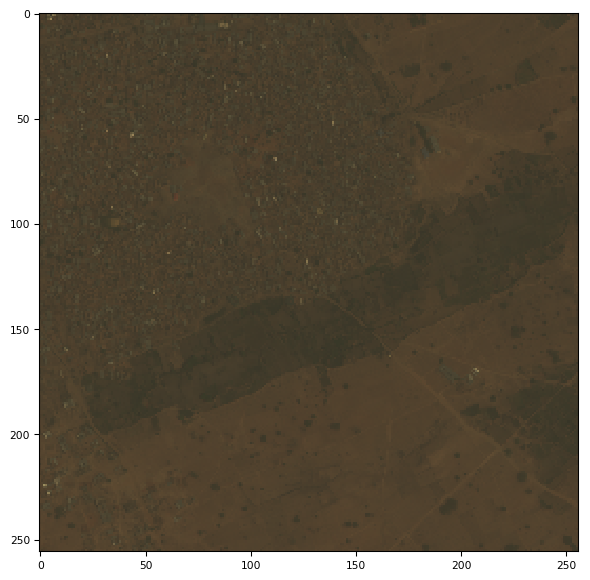

In [40]:
# Visualize an image using the tifffile library (much more light weight than rasterio - no GDAL required)
IMG_TO_VIS = 1
tif.imshow(x_full[IMG_TO_VIS, :, :, :])
plt.show()

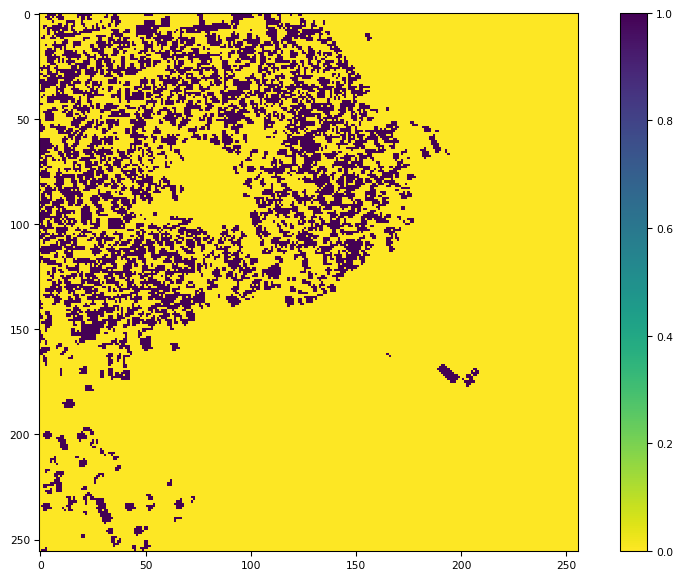

In [41]:
# Visualize a mask using the tifffile library (much more light weight than rasterio)
tif.imshow(y_full[IMG_TO_VIS, :, :, :])
plt.show()

## D. - Setup Model and Run U-Net Baseline

#### Split into train/valid

In [49]:
TRAIN_SPLIT = 0.8

NUM_TRAIN = int(np.ceil(x_full.shape[0] * TRAIN_SPLIT))
x_train, x_valid = x_full[:NUM_TRAIN, ...].copy(), x_full[NUM_TRAIN:, ...].copy()
y_train, y_valid = y_full[:NUM_TRAIN, ...].copy(), y_full[NUM_TRAIN:, ...].copy()


print("Y Train Shape: ", y_train.shape)
print("X Train Shape: ", x_train.shape)
print("X Validation Shape: ", x_valid.shape)
print("Y Validation Shape: ", y_valid.shape)

Y Train Shape:  (10, 256, 256, 1)
X Train Shape:  (10, 256, 256, 3)
X Validation Shape:  (2, 256, 256, 3)
Y Validation Shape:  (2, 256, 256, 1)


#### Setup the loss functions, metrics and model

In [54]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### We need to decide on the correct metrics to evaluate the model:

#### For the DSTL competition, the metric of Jaccard coefficient was used:
The Jaccard coefficient is a common method of measuring the effectivness of a segmentation algorithm:
$$Jaccard = {\frac{TP}{TP+FP+FN} }= {{|A \cap B|}\over{|A \cup B|}} = {{|A \cap B|}\over{|A| + |B| - |A \cap B|}}$$

See -- https://en.wikipedia.org/wiki/Jaccard_index

#### If we use the jaccard coefficient, there is a jaccard distance loss function I found from this location: https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/losses/jaccard.py

#### For another more recent segmentation competition on Kaggle (https://www.kaggle.com/c/data-science-bowl-2018#evaluation) the Mean IoU metric was used.
- See that link for a description


## I am not sure the best metric to use, or the best loss function, but we can stick with Binary Cross Entropy for now ( as Barak said to do)

In [55]:
def jaccard_coef(y_true, y_pred, smooth=1e-12):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

def jaccard_distance(y_true, y_pred, smooth=100):
    # Taken from: https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/losses/jaccard.py
    """Jaccard distance for semantic segmentation, also known as the intersection-over-union loss.
    This loss is useful when you have unbalanced numbers of pixels within an image
    because it gives all classes equal weight. However, it is not the defacto
    standard for image segmentation.
    For example, assume you are trying to predict if each pixel is cat, dog, or background.
    You have 80% background pixels, 10% dog, and 10% cat. If the model predicts 100% background
    should it be be 80% right (as with categorical cross entropy) or 30% (with this loss)?
    The loss has been modified to have a smooth gradient as it converges on zero.
    This has been shifted so it converges on 0 and is smoothed to avoid exploding
    or disappearing gradient.
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    # References
    Csurka, Gabriela & Larlus, Diane & Perronnin, Florent. (2013).
    What is a good evaluation measure for semantic segmentation?.
    IEEE Trans. Pattern Anal. Mach. Intell.. 26. . 10.5244/C.27.32.
    https://en.wikipedia.org/wiki/Jaccard_index
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec))

In [56]:
def U_Net(img_shape):
    inputs = Input(img_shape)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = Conv2DTranspose(256, 2, strides=2, padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(128, 2, strides=2, padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(64, 2, strides=2, padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(32, 2, strides=2, padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, 
                  outputs=outputs)
    return model

In [87]:
# Run with Binary Cross Entropy Loss
model = U_Net(img_shape=x_train.shape[1:])

model.compile(optimizer='adam', 
              loss='binary_crossentropy', # plug in jaccard_distance here to try that loss function defined above
              metrics=['accuracy', 
                       jaccard_coef, 
                       mean_iou])

model.fit(x_train, y_train, 
          batch_size=10, 
          epochs=10, 
          verbose=1, 
          shuffle=True, 
          validation_data=(x_valid, y_valid))

Train on 10 samples, validate on 2 samples
Epoch 1/10
10/10 [==============================] - 22s 2s/step - loss: 0.6824 - acc: 0.9067 - jaccard_coef: 0.0834 - mean_iou: 0.0000e+00 - val_loss: 0.6706 - val_acc: 0.9248 - val_jaccard_coef: 0.0676 - val_mean_iou: 0.4542
Epoch 2/10
10/10 [==============================] - 19s 2s/step - loss: 0.6575 - acc: 0.9083 - jaccard_coef: 0.0829 - mean_iou: 0.4555 - val_loss: 0.6511 - val_acc: 0.9248 - val_jaccard_coef: 0.0671 - val_mean_iou: 0.4549
Epoch 3/10
10/10 [==============================] - 20s 2s/step - loss: 0.6298 - acc: 0.9083 - jaccard_coef: 0.0823 - mean_iou: 0.4555 - val_loss: 0.6196 - val_acc: 0.9248 - val_jaccard_coef: 0.0662 - val_mean_iou: 0.4551
Epoch 4/10
10/10 [==============================] - 18s 2s/step - loss: 0.5868 - acc: 0.9083 - jaccard_coef: 0.0811 - mean_iou: 0.4555 - val_loss: 0.5467 - val_acc: 0.9248 - val_jaccard_coef: 0.0639 - val_mean_iou: 0.4552
Epoch 5/10
10/10 [==============================] - 18s 2s/step -

### Have a look at the predicted masks

Note: The cutoff parameter should be 0.5, but it doesn't work currently, so ya......

In [91]:
def plot_predictions(x_data, y_data, model, img_index=1, CUTOFF=0.2):
    predicted_masks = model.predict(x_data)

    tif.imshow(x_data[img_index, :, :, :])
    tif.imshow(y_data[img_index, :, :, :])
    tif.imshow(predicted_masks[img_index, :, :, :] > CUTOFF)
    
    plt.show()

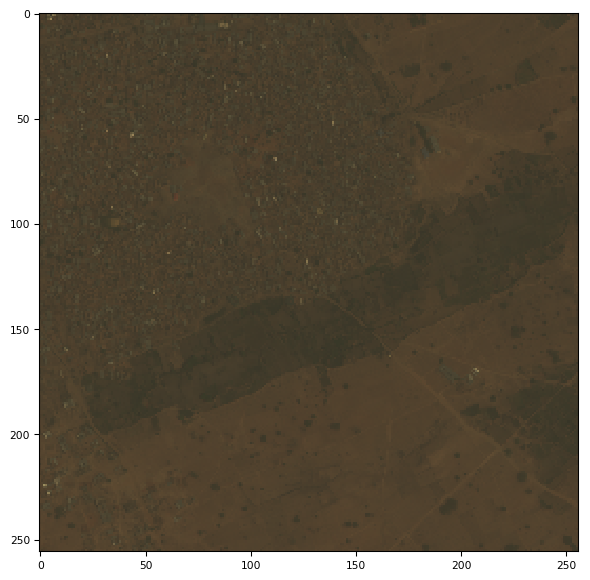

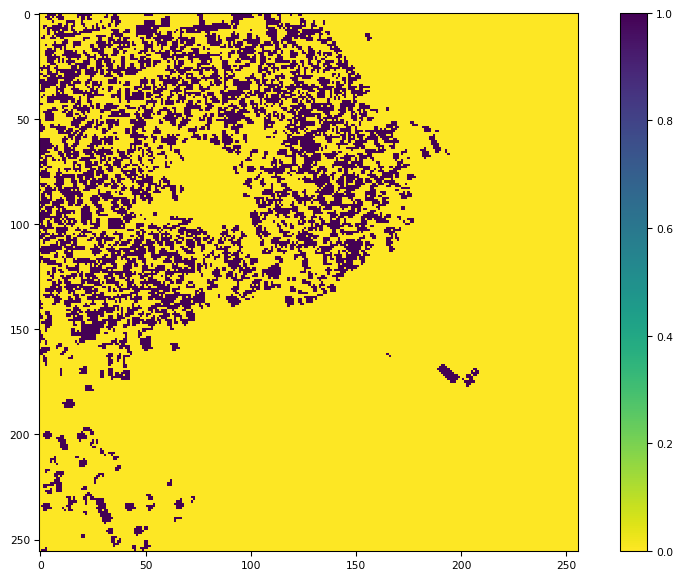

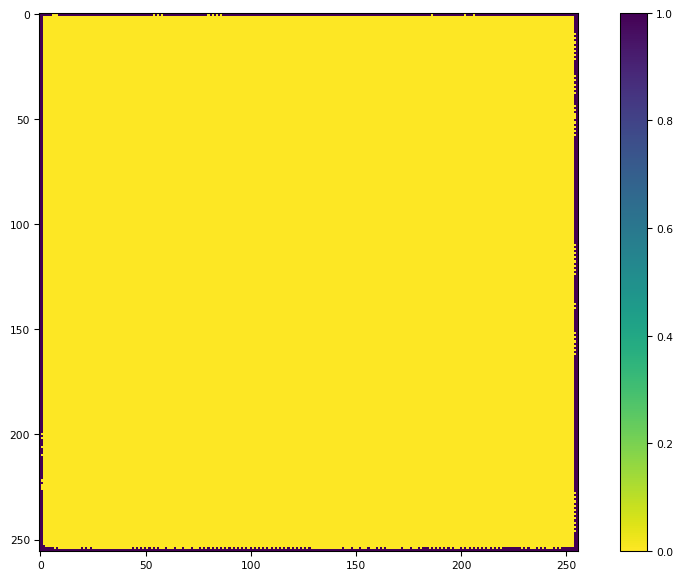

In [92]:
# Try plotting predictions on training data
plot_predictions(x_train, y_train, model)

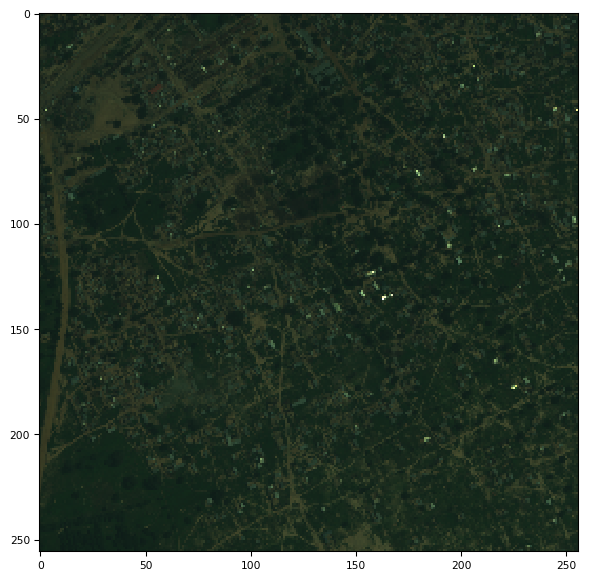

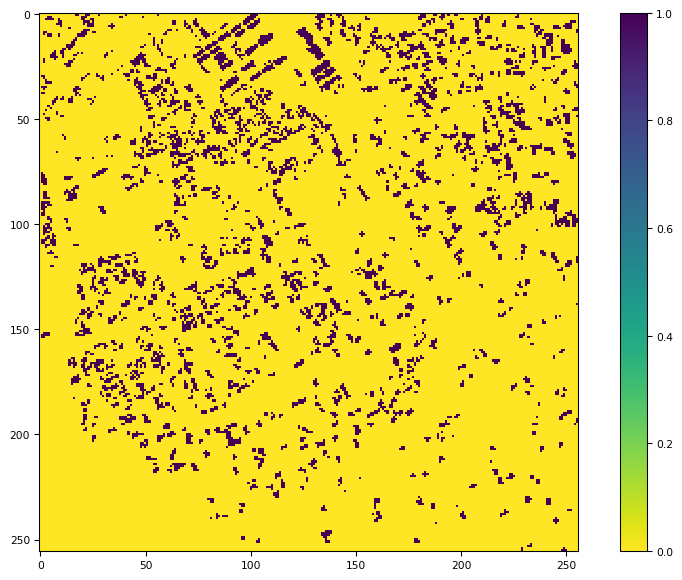

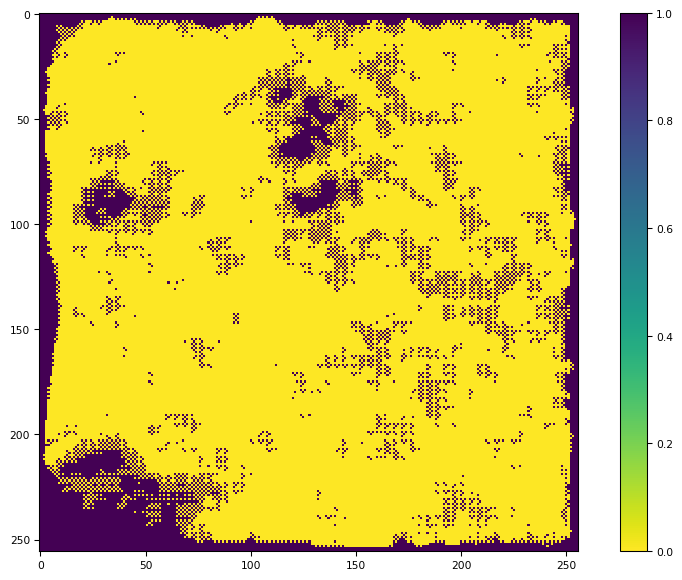

In [93]:
plot_predictions(x_valid, y_valid, model)

## Conclusion

 1) It looks like our loss is going down, so we are learning something, but the predicted masks are shit. The jaccard coefficient seems to be going down but the mean_iou does up, so we need to think this through more
 
 2) We need to change the U-Net model and add regularization (dropout) as well as batch norm. The model came out 2 months before the Batch Norm paper, which is why it doesn't use it by default
     - For the paper see: https://arxiv.org/abs/1505.04597
 3) We need to create an autoencoder version, to do this we need to do two things:
 
     1) Use the data load in function with an image ID list of more than 25 images (i.e. don't use the find_images_with_mask function to get a set of image_ids)
     2) Modify the above U-Net to have 3 dimensions in the final Conv2D instead of 1
     3) Train with an l2 loss function
 

## Appendix A. - Info about converting the polygons to Raster images (tiff files)
#### The DSTL images have had their geo-coordinates normalized to hide the location the images were taken, as a result we need to use the below equations to get the correct Width and Height of each image:

$$W^\prime = W \cdot \frac{W} {W+1}$$
$$x^\prime = \frac{x}{x_{max}} \cdot W^\prime$$
$$H^\prime = H \cdot \frac{H}{H+1}$$
$$y^\prime = \frac{y}{y_{min}}\cdot H^\prime$$

The X_max and Y_min values are stored in the grid_sizes csv

This was done already, and the files were stored in the 'labels' directory

In [3]:
# Have a look at the grid_sizes if you desire
grid_sizes = pd.read_csv('../../data/dstl_images/grid_sizes.csv')
grid_sizes.rename(columns={'Unnamed: 0': 'ImageId'}, 
                  inplace=True)
print("There are {} images in total".format(grid_sizes.shape[0]))
grid_sizes.head()

There are 450 images in total


,ImageId,Xmax,Ymin
0,6120_2_4,0.009180,-0.00904
1,6120_2_3,0.009169,-0.00904
2,6120_2_2,0.009188,-0.00904
3,6120_2_1,0.009188,-0.00904
4,6120_2_0,0.009188,-0.00904
